In [41]:
import sys
sys.path.append('../lib')
from table_detection import Pipeline, TableMask, Table,process_column_mask, process_line_mask, LineDetection
from tablenet import TableNet
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
import json
from utils import *
import pandas as pd
from collections import namedtuple
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
%matplotlib inline

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('models/2020_09_24')
model.load_weights(latest)

In [50]:
images = [os.path.join('../data/ocr/',file) for file in os.listdir('../data/ocr/') if file.split('.')[-1]=='jpg']

In [51]:
image = plt.imread(os.path.join('../data/ocr/',"3760048991056.nutrition.jpg"))

In [52]:
%%time
pipeline = Pipeline(model,image)
pipeline.run(0.8)
table = Table(pipeline.predicted_column_mask,pipeline.predicted_line_mask,image.shape)
table.find_table()

std
std
Wall time: 2.22 s


In [53]:
img = image.copy()

In [54]:
for line in table.table:
    for cell in line:
        cv2.rectangle(img,(cell.xmin,cell.ymin),(cell.xmax,cell.ymax),color=(255,0,0),thickness=5)

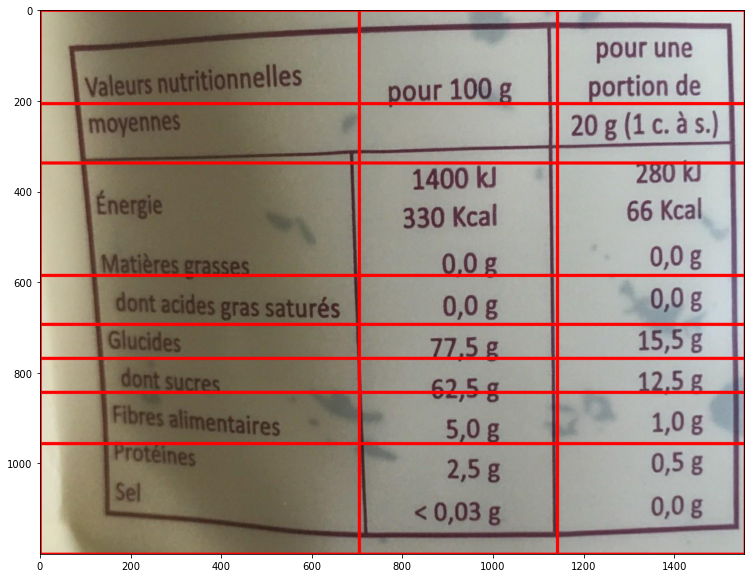

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [87]:
mask = table.line_mask.astype(np.uint8)

In [70]:
with open(os.path.join('../data/ocr/',"3760048991056.nutrition.json")) as file:
    bounding_boxes = json.load(file)['words']

In [71]:
def circumscribed_rectangle(bounding_box):
    '''
    get circumscribed rectangle for this kind of bounding box
     ----------------
    |1-------------2|
    | \           / | 
    |   4--------3  |
    -----------------
    '''
    pt1 = bounding_box[0]
    pt2 = bounding_box[1]
    pt3 = bounding_box[2]
    pt4 = bounding_box[3]
    x1 = min(pt1['x'],pt4['x'])
    y1 = min(pt1['y'],pt2['y'])
    x2 = max(pt2['x'],pt3['x'])
    y2 = max(pt3['y'],pt4['y'])
    return Rectangle(x1,y1,x2,y2)

def dist(x1,x2):
    return abs(x1-x2)

def area(rect):
    l = rect.xmax-rect.xmin
    h = rect.ymax-rect.ymin
    return l*h


def intersection_area(rect1,rect2):
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

def dist_score(rect1,rect2):
    x1 = Rectangle
    x2 = rect2[0]
    l = rect1[2]
    return dist(x1,x2)/l

In [78]:
bounding_boxes

[{'text': 'pour',
  'bounding_box': [{'x': 1226, 'y': 71},
   {'x': 1339, 'y': 65},
   {'x': 1341, 'y': 112},
   {'x': 1228, 'y': 118}]},
 {'text': 'une',
  'bounding_box': [{'x': 1356, 'y': 70},
   {'x': 1437, 'y': 66},
   {'x': 1439, 'y': 103},
   {'x': 1358, 'y': 107}]},
 {'text': 'portion',
  'bounding_box': [{'x': 1210, 'y': 147},
   {'x': 1383, 'y': 140},
   {'x': 1385, 'y': 198},
   {'x': 1212, 'y': 205}]},
 {'text': 'de',
  'bounding_box': [{'x': 1402, 'y': 141},
   {'x': 1455, 'y': 139},
   {'x': 1457, 'y': 188},
   {'x': 1404, 'y': 190}]},
 {'text': '20',
  'bounding_box': [{'x': 1172, 'y': 231},
   {'x': 1229, 'y': 231},
   {'x': 1229, 'y': 277},
   {'x': 1172, 'y': 277}]},
 {'text': 'g',
  'bounding_box': [{'x': 1253, 'y': 220},
   {'x': 1285, 'y': 220},
   {'x': 1286, 'y': 290},
   {'x': 1254, 'y': 290}]},
 {'text': '(1',
  'bounding_box': [{'x': 1290, 'y': 225},
   {'x': 1332, 'y': 225},
   {'x': 1332, 'y': 286},
   {'x': 1290, 'y': 286}]},
 {'text': 'c.',
  'bounding_box

In [72]:
words = bounding_boxes.copy()
shape = pipeline.images[-1].shape
table_shape = (np.array(table.table).shape[0],np.array(table.table).shape[1])
extracted_table = np.empty(shape=table_shape+(0,)).tolist()
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        done=False
        word_rect = circumscribed_rectangle(bounding_box['bounding_box'])
        word_area = area(word_rect)
        for col_num,col in enumerate(table.table):
            col_x_min = col[0].xmin
            col_x_max = col[0].xmax
            column_rect = Rectangle(col_x_min,0,col_x_max,shape[1])
            inclusion_score = intersection_area(column_rect,word_rect)/word_area
            #print('{} included in col {} with score of {}'.format(bounding_boxes[i]['text'],col_num,inclusion_score))
            if inclusion_score>0.5:
                for line_num,cell in enumerate(col):
                    inclusion_score = intersection_area(cell,word_rect)/word_area
                    if inclusion_score>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(bounding_boxes[i]['text'])
                        done=True
                        break
                if done:
                    break
        if col_num == len(table)-1 and line_num == len(col)-1:
            print(bounding_boxes[i]['text'])
                    
    except KeyboardInterrupt:
        print("Interrupted")
        break
    except:
        words.remove(bounding_box)

66it [00:00, 10911.04it/s]


In [73]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)

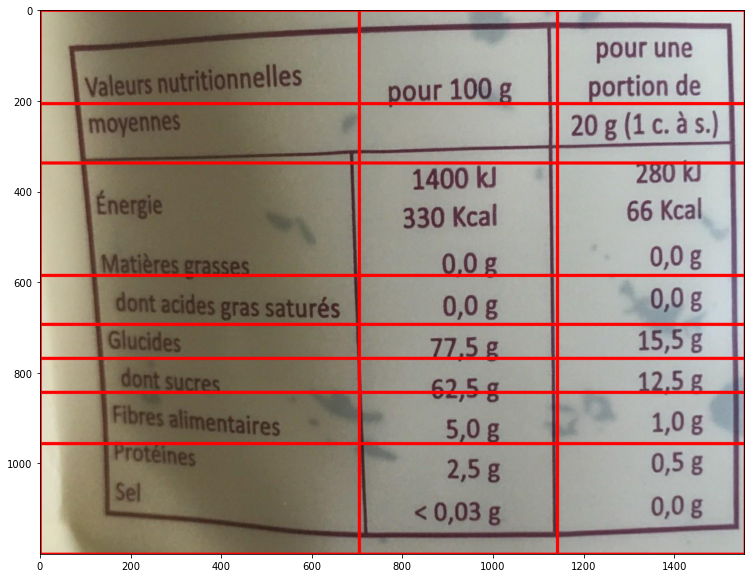

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [75]:
a = pd.DataFrame(extracted_table).applymap(lambda x: ' '.join(x)).T.replace('',np.nan)

In [77]:
a

,0,1,2
0,Valeurs nutritionnelles,pour 100 g,pour une portion de
1,moyennes,NaN,20 g (1 c. à s.)
2,Énergie Matières grasses,"1400 kJ 330 Кcal 0,0 g","280 kJ 66 Kcal 0,0 g"
3,dont acides gras saturés,"0,0 g","0,0g"
4,Glucides,"77,5 g","15,5 g"
5,dont sucres,"62,5 g","12,5 g"
6,Fibres alimentaires,"5,0 g","1,0 g"
7,Protéines Sel,"2,5 g < 0,03 g","0,5 g 0,0 g"


In [122]:
words = bounding_boxes.copy()
shape = pipeline.images[-1].shape
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        done=False
        points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
        word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
        for col_num,col in enumerate(table):
            column_mask = cv2.rectangle(np.zeros(shape),(columns[col_num],0),(columns[col_num+1],shape[1]),color=(255,255,255),thickness=-1)
            if inclusion_score(word_mask,column_mask)>0.5:
                for line_num,cell in enumerate(col):
                    column_mask = cv2.rectangle(np.zeros(shape),cell[0],cell[1],color=(255,255,255),thickness=-1)
                    if inclusion_score(word_mask,column_mask)>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(bounding_boxes[i]['text'])
                        done=True
                        break
                if done:
                    break
                    
    except KeyboardInterrupt:
        print("Interrupted")
        break
    except:
        words.remove(bounding_box)

22it [00:04,  5.14it/s]

Interrupted


In [245]:
words = bounding_boxes.copy()
shape = pipeline.images[-1].shape
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        done=False
        points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
        word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
        for col_num,col in enumerate(table.table):
            column_mask = cv2.rectangle(np.zeros(shape),(columns[col_num],0),(columns[col_num+1],shape[1]),color=(255,255,255),thickness=-1)
            if inclusion_score(word_mask,column_mask)>0.5:
                for line_num,cell in enumerate(col):
                    column_mask = cv2.rectangle(np.zeros(shape),cell[0],cell[1],color=(255,255,255),thickness=-1)
                    if inclusion_score(word_mask,column_mask)>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(bounding_boxes[i]['text'])
                        done=True
                        break
                if done:
                    break
    except KeyboardInterrupt:
        print("You pressed ctrl c...")
        break
    except:
        words.remove(bounding_box)

105it [00:00, 897.81it/s]


In [27]:
with open('example.json','w') as file:
    json.dump(words, file)

In [4]:
with open('example.json') as file:
    words = json.load(file)

In [ ]:
table = pd.DataFrame(words)
table.cell = table.cell.apply(lambda x: '-'.join(x))

In [12]:
pd.DataFrame(words).groupby('cell')['text'].transform(lambda x: ','.join(x))

TypeError: unhashable type: 'list'

In [316]:
column_mask_processor.peaks

[30, 448, 561]

In [322]:
table[3]

[((561, 0), (705, 31)),
 ((561, 31), (705, 158)),
 ((561, 158), (705, 296)),
 ((561, 296), (705, 411)),
 ((561, 411), (705, 596)),
 ((561, 596), (705, 786)),
 ((561, 786), (705, 976)),
 ((561, 976), (705, 1012))]

In [114]:
words = bounding_boxes.copy()
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        for j,(x1,x2) in enumerate(column_mask_processor.column_areas[1:]):
            points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
            shape = pipeline.images[-1].shape
            column_mask = cv2.rectangle(np.zeros(shape),(x1,0),(x2,shape[0]),color=(255,255,255),thickness=-1)
            word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
            #print("{} : {}".format(bounding_box['text'],inclusion_score(word_mask,column_mask)))
            if inclusion_score(word_mask,column_mask)>0.5:
                bounding_boxes[i]['column']=j
                break
    except:
        pass

105it [00:14,  7.44it/s]


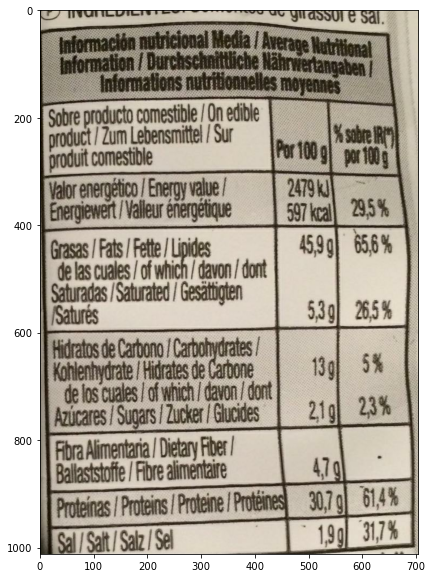

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(pipeline.images[-1])

In [45]:
line = line_mask_processor.column_areas[1]

In [46]:
img = cv2.rotate(rotated.copy(),cv2.ROTATE_90_CLOCKWISE)

In [47]:
line_mask_processor.column_areas[3]

[288, 419]

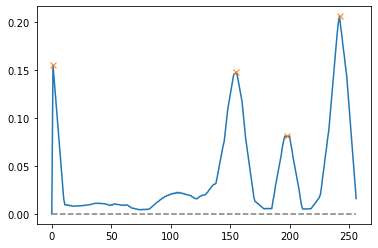

In [208]:
signal = line_mask_processor.signal
signal_peaks = line_mask_processor.signal_peaks
plt.plot(signal)
plt.plot(signal_peaks, signal[signal_peaks], "x")
plt.plot(np.zeros_like(signal), "--", color="gray")

In [185]:
for line in line_mask_processor.column_areas:
    cv2.line(img,(0,line[0]),(img.shape[1],line[0]),color=(255,0,0))

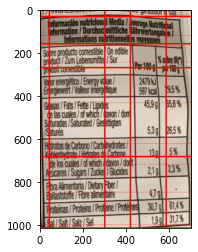

In [186]:
plt.imshow(img)

In [51]:
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        for j,(x1,x2) in enumerate(line_mask_processor.column_areas[1:]):
            points = np.array([[[p['x'],p['y']] for p in bounding_box['bounding_box']]])
            shape = pipeline.images[-1].shape
            column_mask = cv2.rectangle(np.zeros(shape),(0,x1),(shape[0],x2),color=(255,255,255),thickness=-1)
            word_mask = cv2.fillPoly(np.zeros(shape),points,(255,255,255))
            #print("{} : {}".format(bounding_box['text'],inclusion_score(word_mask,column_mask)))
            if inclusion_score(word_mask,column_mask)>0.5:
                bounding_boxes[i]['line']=j
                break
    except:
        pass

105it [00:36,  2.86it/s]


In [12]:
for image in tqdm.tqdm(images):
    try:
        pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(image))))
        pipeline.run(0.8)
        plt.imsave(os.path.join('../results/table_detected/',image.split('/')[-1]),pipeline.images[-1].numpy())
      #  column_mask_processor = ColumnMaskProcessor(pipeline.images[-1],pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8'))
      #  column_mask_processor.process_mask()
      #  column_mask_processor.get_peaks(20,25)
      #  column_mask_processor.find_column_areas()
        
      #  pipeline.tm_list[-1].draw_bounding_box()
      #  plt.figure(figsize=(10,5))
      #  plt.title("Original Image")
      #  plt.imshow(pipeline.tm_list[0].image)
      #  plt.figure(figsize=(10,5))
      #  plt.title("Detected Table")
      #  plt.imshow(pipeline.tm_list[-1].image_with_bounding_box)
      #  plt.figure(figsize=(5,1))
      #  plt.plot(column_mask_processor.signal)
      #  plt.plot(column_mask_processor.signal_peaks, column_mask_processor.signal[column_mask_processor.signal_peaks], "x")
      #  plt.plot(np.zeros_like(column_mask_processor.signal), "--", color="gray")
      #  plt.show()
      #  
      #  plt.figure(figsize=(20,10))
      #  for num, area in enumerate(column_mask_processor.column_areas):
      #      plt.subplot(1,len(column_mask_processor.column_areas),num+1)
      #      plt.title("column {}".format(num))
      #      plt.axis('off')
      #      plt.imshow(area)
      #      plt.imsave(os.path.join('../data/line_detection_data/',image.split('/')[-1]),cv2.rotate(pipeline.images[-1].numpy(), cv2.ROTATE_90_CLOCKWISE))
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:29<00:00,  2.45s/it]
